# Dataset Cleaning and Augmentation

Check AIcrowd Notebook for detail analysis of the dataset: <br>
https://www.aicrowd.com/showcase/food-recognition-benchmark-data-exploration-baseline

## Packages

In [5]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import hub
from glob import glob
import json
import os
from PIL import Image, ImageDraw
from pycocotools.coco import COCO
import time
from tqdm import tqdm
import cv2

In [3]:
# Activeloop Settings
%env BUGGER_OFF=True
!activeloop reporting --off

env: BUGGER_OFF=True


# Downloading Dataset

In [1]:
# Login to AIcrowd
!pip install aicrowd-cli > /dev/null
!aicrowd login

Please login here: https://api.aicrowd.com/auth/yg-D7x7-l8m_vPSd-75V12PN0TL4D5t72oncWk4Pk14
Opening in existing browser session.
[166463:166463:0100/000000.148707:ERROR:sandbox_linux.cc(377)] InitializeSandbox() called with multiple threads in process gpu-process.
API Key valid
Saved API Key successfully!


In [2]:
# List dataset for this challenge
!aicrowd dataset list -c food-recognition-benchmark-2022

                          Datasets for challenge #962                           
┌───┬────────────────────────────────┬────────────────────────────────┬────────┐
│ # │ Title                          │ Description                    │   Size │
├───┼────────────────────────────────┼────────────────────────────────┼────────┤
│ 0 │ public_validation_set_2.0.tar… │ Validation Dataset (contains   │    59M │
│   │                                │ 1000 images and 498            │        │
│   │                                │ categories, with annotations)  │        │
│ 1 │ public_test_release_2.0.tar.gz │ [Public] Testing Dataset       │   197M │
│   │                                │ (contains 3000 images and 498  │        │
│   │                                │ categories, without            │        │
│   │                                │ annotations)                   │        │
│ 2 │ public_training_set_release_2… │ Training Dataset (contains     │ 2.14GB │
│   │                       

In [ ]:
# Download dataset
!aicrowd dataset download -c food-recognition-benchmark-2022

In [7]:
# Create data directory
!mkdir -p data/ data/train data/val data/test
!echo "Extracting test dataset" && tar -xvf *test* -C data/test > /dev/null
!echo "Extracting val dataset" &&  tar -xvf *val* -C data/val > /dev/null
!echo "Extracting train dataset" &&  tar -xvf *train* -C data/train > /dev/null

Extracting test dataset
Extracting val dataset
Extracting train dataset


# Processing Dataset - [ Train, Validation ]

In [3]:
# Login to activeloop if using Activeloop Storage (hub://.....)
!activeloop login -u sainikhileshreddy -p password

Successfully logged in to Activeloop.


In [4]:
!ls data/*/

data/test/:
images

data/train/:
annotations.json  images  new_annotations.json

data/val/:
annotations.json  images  new_annotations.json


In [20]:
# In the dataset summary (from first link), we see that there is mismatch in 
# image sizes. So we correct the mismatch before we move forward
def fix_data(directory):
    
    annotations_path = os.path.join(directory, 'annotations.json')
    jsn = json.load(open(annotations_path, 'r'))
    for n, i in enumerate(tqdm((jsn['images']))):
        image_path = os.path.join(directory, 'images', i["file_name"])
        img = Image.open(image_path)
        if img.size[1] != i['height']:
            jsn['images'][n]['height'] = img.shape[1]

        if img.size[0] != i['width']:
            jsn['images'][n]['width'] = img.shape[0]
            
    for index, data in enumerate(tqdm(jsn['annotations'])):
        bbox = data['bbox']
        y, x, h, w = bbox
        jsn['annotations'][index]['bbox'] = [x, y, w, h]
    
    json_path = os.path.join(directory, 'new_annotations.json')
    with open(json_path, 'w') as f:
        json.dump(jsn, f)
        print(f'Annotations modified at {json_path}')

fix_data(os.path.join('data', 'train'))
fix_data(os.path.join('data', 'val'))

100%|████████████████████████████████████████████████████████████████████████████████████████████| 76491/76491 [00:00<00:00, 632154.26it/s]


Annotations modified at data/train/new_annotations.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1830/1830 [00:00<00:00, 1274589.23it/s]


Annotations modified at data/val/new_annotations.json


In [34]:
base_path = os.path.join(os.getcwd(), 'data')

# Valid choices are 'train' and 'val'. 
# Testing is a special case at the end of the notebook
data_type='train' 

hub_path = 'hub://sainikhileshreddy/food-recognition-2022-{}'.format(data_type)
# hub_path = './{}'.format(data_type)

# Specify dataset path
# Set overwrite = True if you need to start over
ds = hub.empty(hub_path, overwrite = True) 

Your Hub dataset has been successfully created!
The dataset is private so make sure you are logged in!
This dataset can be visualized at https://app.activeloop.ai/sainikhileshreddy/food-recognition-2022-train.


In [30]:
hub.delete(hub_path, large_ok=True)

In [35]:
annotation_file = os.path.join(base_path, data_type, 'new_annotations.json')
images_root = os.path.join(base_path, data_type, 'images')
coco = COCO(annotation_file)
category_info = coco.loadCats(coco.getCatIds())
cat_names = [category['name'] for category in category_info]
super_cat_names = list(set([category['supercategory'] for category in category_info]))

loading annotations into memory...
Done (t=5.63s)
creating index...
index created!


In [ ]:
img_ids = sorted(coco.getImgIds()) # Image ids for uploading
count = 0

start_time = time.time()
with ds:
    
    ## ---- Create Tensors ----- ##
    ds.create_tensor('images', htype = 'image', sample_compression = 'jpg')
    ds.create_tensor('images_meta', htype = 'json')
    ds.create_tensor('masks', htype = 'binary_mask', sample_compression = 'lz4')
    ds.create_tensor('boxes', htype = 'bbox')
    ds.boxes.info.update(coords = {'type': 'pixel', 'mode': 'LTWH'})
    ds.create_tensor('categories', htype = 'class_label', class_names = cat_names)
    ds.create_tensor('super_categories', htype = 'class_label', class_names = super_cat_names)
    ds.create_tensor('areas', dtype = 'uint32')
    ds.create_tensor('iscrowds', dtype = 'bool')
    
    ## ---- Iterate through each image and upload data ----- ##
    for count, img_id in enumerate(tqdm(img_ids)):
        ann_ids = coco.getAnnIds(img_id)
        anns = coco.loadAnns(ann_ids)
        
        img_coco = coco.loadImgs(img_id)[0]
        img_fn = os.path.join(images_root, img_coco['file_name'])
        img = Image.open(img_fn)
        dims = img.size
        
        
        #Iterate through annotations and parse each
        
        #First Create empty arrays for all annotations
        masks = np.zeros((dims[1], dims[0], len(anns)))
        boxes = np.zeros((len(anns),4))
        categories = np.zeros((len(anns)))
        supercats = np.zeros((len(anns)))
        areas = np.zeros((len(anns)))
        iscrowds = np.zeros((len(anns)))
        supercats = np.zeros((len(anns)))
        
        #Then populate the arrays with the annotations data
        for i, ann in enumerate(anns):
            mask = coco.annToMask(ann) #Convert annotation to mask
            masks[:,:,i] = mask
            boxes[i,:] = ann['bbox']
            
            # Do a brute force search and make no assumptions between order of relationship of category ids
            categories[i] = cat_names.index([category_info[i]['name'] for i in range(len(category_info)) if category_info[i]['id']==ann['category_id']][0])
            supercats[i] = super_cat_names.index([category_info[i]['supercategory'] for i in range(len(category_info)) if category_info[i]['id']==ann['category_id']][0])
            
            areas[i] = ann['area']
            iscrowds[i] = ann['iscrowd']            

            if 'segmentation' not in ann:
                print('--- No segmentation found in annotations. ---')
                print('Annotation length: {}'.format(len(anns)))
                print('--- image id: {} ---'.format(img_id))
                
        
        #Append data to hub. Only do this after all annotations have been parsed.
        try:
            ds.images.append(hub.read(img_fn, verify = True))
            ds.images_meta.append(img_coco)
            ds.masks.append(masks.astype('bool'))
            ds.boxes.append(boxes.astype('float32'))
            ds.categories.append(categories.astype('uint32'))
            ds.super_categories.append(supercats.astype('uint32'))
            ds.areas.append(areas.astype('uint32'))
            ds.iscrowds.append(iscrowds.astype('bool'))

        except Exception as e:
            print(e)

#         if count > 0 and count%100==0:
#             print('Uploaded {} images'.format(count))
        
#         if count > 40:
#             break;

    print('Finished')
    
end_time = time.time()

print('Upload took {} seconds for {} images'.format(end_time-start_time, count))

# Processing Dataset - [ Test ] - Special Case COCO

In [31]:
base_path = os.path.join(os.getcwd(), 'data')

# Special case - COCO Test dataset without annotations
data_type='test' 

In [32]:
# hub_path = 'hub://sainikhileshreddy/food-recognition-2022-{}'.format(data_type)
hub_path = './{}'.format(data_type)

# Specify dataset path
# Set overwrite = True if you need to start over
ds = hub.empty(hub_path, overwrite = True)

images_path = glob(os.path.join(base_path, data_type, 'images', '*.jpg'))

In [158]:
# hub.delete(hub_path, large_ok=True)

In [33]:
start_time = time.time()

with ds:
    
    ds.create_tensor('images', htype = 'image', sample_compression = 'jpg')
    ds.create_tensor('images_meta', htype = 'json')
    
    for (index, image_path) in enumerate(tqdm(images_path)):

        image_name = image_path.split('/')[-1]
        image_id = image_name.split('.')[0]

        image = Image.open(image_path)
        (width, height) = image.size
        meta = {
            'id' : image_id,
            'file_name' : image_name,
            'width' : width,
            'height' : height
        }
        
        ds.images.append(hub.read(image_path))
        ds.images_meta.append(meta)
        # print(f'{index} -> {image_name}')

end_time = time.time()

print('Upload took {} seconds for {} images'.format(end_time-start_time, index))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:50<00:00, 59.07it/s]


Upload took 51.002695083618164 seconds for 2999 images


# Verify the dataset

In [1]:
# Login to activeloop if using Activeloop Storage (hub://.....)
!activeloop login -u sainikhileshreddy -p password

Successfully logged in to Activeloop.


In [4]:
hub_path = 'hub://sainikhileshreddy/food-recognition-2022-train'
ds = hub.dataset(hub_path)

hub://sainikhileshreddy/food-recognition-2022-train loaded successfully.
This dataset can be visualized at https://app.activeloop.ai/sainikhileshreddy/food-recognition-2022-train.


[  2.6625  11.1825 127.8    339.2025]
[ 93.1875  44.73   218.325  266.7825]
[266.7825  78.81   154.425  342.3975]
[273.1725 250.275  136.32    89.9925]


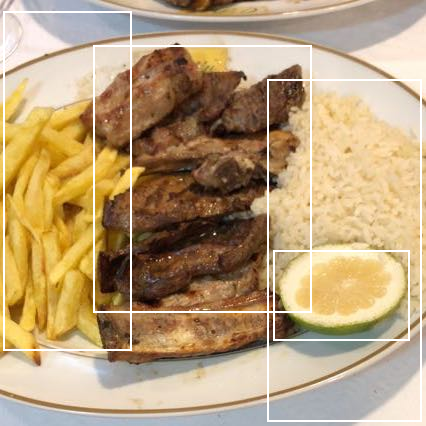

In [10]:
index = 29
image = Image.fromarray(ds.images[index].numpy())
boxes = ds.boxes[index].numpy()
draw = ImageDraw.Draw(image)

for b in range(boxes.shape[0]):
    print(boxes[b]) # y, x, height, width
    x, y, w, h = [round(data) for data in boxes[b]]
    
    (x1,y1) = (x, y)
    (x2,y2) = (x+w, y+h)
    draw.rectangle([x1,y1,x2,y2], width=2)
image